In [1]:
from RLTrain import Opt
import os
import time
#print(Opt())
import pandas as pd
from RadarGraph import *
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]=14.0
import sys
sys.path.append('../')

from visualization_helper import *

In [2]:
def plotabt(all_acts,actions,colors,labels,points,names,title_ext="",title=None,ylim=(-0.15,1.15)):
    """Plotting Function for actions vs time
    Inputs:
        all_act (list<np.array>) -- shape is [number of models, number of timesteps, number of actions]
        actions (list<str>) -- list of the name of each action
        colors (list<str>) -- list of colors (should be at least as long as the number of models)
        names (list<str>) -- the names of each model
        title_ext (str) -- addition you want to add to the end of the graph title
    
    """
    fig, axs = plt.subplots(figsize=(12, 5), nrows=len(actions), ncols=len(all_acts[0]))
    fig.subplots_adjust(wspace=0.0, hspace=0.0, top=0.85, bottom=0.05)
    for i,ax0 in enumerate(axs):
        for k,all_act in enumerate(all_acts):
            for j,act in enumerate(all_act):
                axs[0][j].set_title(names[j])
                ax=ax0[j]
                ax.plot(act[:,i],points[k],color=colors[k],ms=3,alpha=0.5,label=labels[k])
                ax.set_ylim(*ylim)
                if j!=0:
                    ax.set_yticks([])
                    #ax.set_yticks([int(a) for a in ylim])
                #ax.legend()
        ax.text(act.shape[0],ylim[1]*0.5,actions[i],horizontalalignment="right",verticalalignment="top"
                ,bbox=dict(boxstyle="square",facecolor="w",edgecolor="k",alpha=0.8))
    if title is None:
        axs[0][(int(len(names)-0.5)//2)-1].text(2,2,"Average Value of Each Action vs Step %s"%title_ext)
    else:
        axs[0][(int(len(names)-0.5)//2)-1].text(2,2,title)
    #axs[0,-1].legend(names,loc=(0.8, .0))
    axs[-1,0].set_xlabel("Step")
    
    
def mean_stdv_step_n(data,interp_steps=1,steps=20):
    alt_data=data.reshape([data.shape[0],data.shape[1]//interp_steps,interp_steps])
    alt_data=alt_data.transpose(0,2,1)
    alt_data=alt_data.reshape([data.shape[0]*interp_steps,data.shape[1]//interp_steps])
    mean=alt_data.mean(axis=0)
    stdv=(alt_data.var(axis=0))**0.5
    steps=np.arange(mean.shape[0])*steps*interp_steps
    N=alt_data.shape[0]
    return mean,stdv,steps,N

# Wurtz React

In [3]:
parent_dir = "MODELS\\GenWurtzReact-v1"

folders = load_rollouts(parent_dir,obj=None,last=False)
gheuristic = pd.read_pickle("MODELS\\GenWurtzReact-v1\\Heuristic/rollout")

## Returns during Training

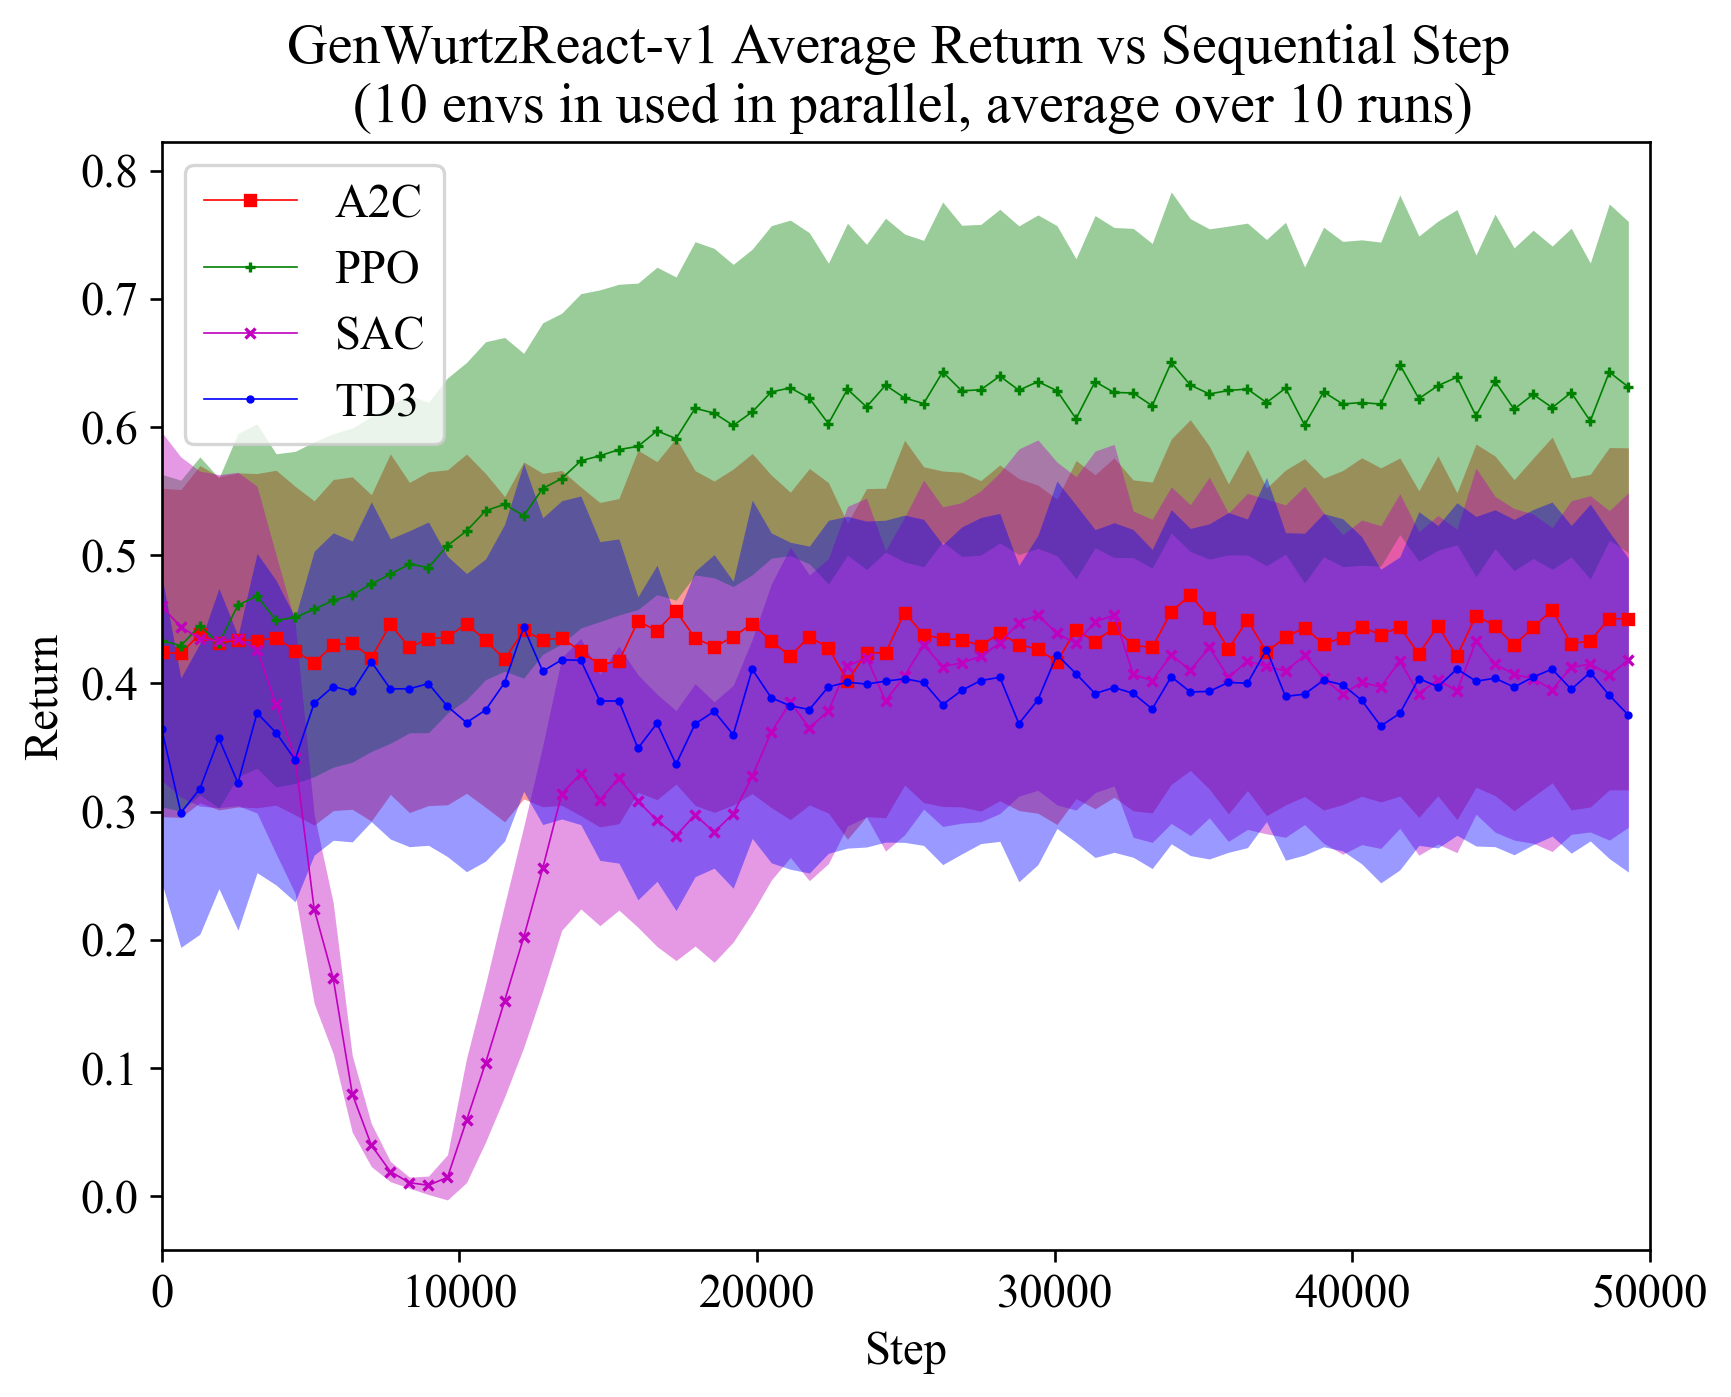

In [4]:
fig = plt.figure(1,figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=20,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=32)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv/5,mean+stdv/5,color=colors[i],alpha=0.4,lw=0)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend()    
plt.savefig("Legacy/Figures/WurtzReact/GenWurtzReactRuns.pdf",bbox_inches='tight')
plt.title("GenWurtzReact-v1 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

## Returns VS Targets

Text(0.5, 0.8, 'Average Return VS Target Material (Best model trained with 0.5M Steps)')

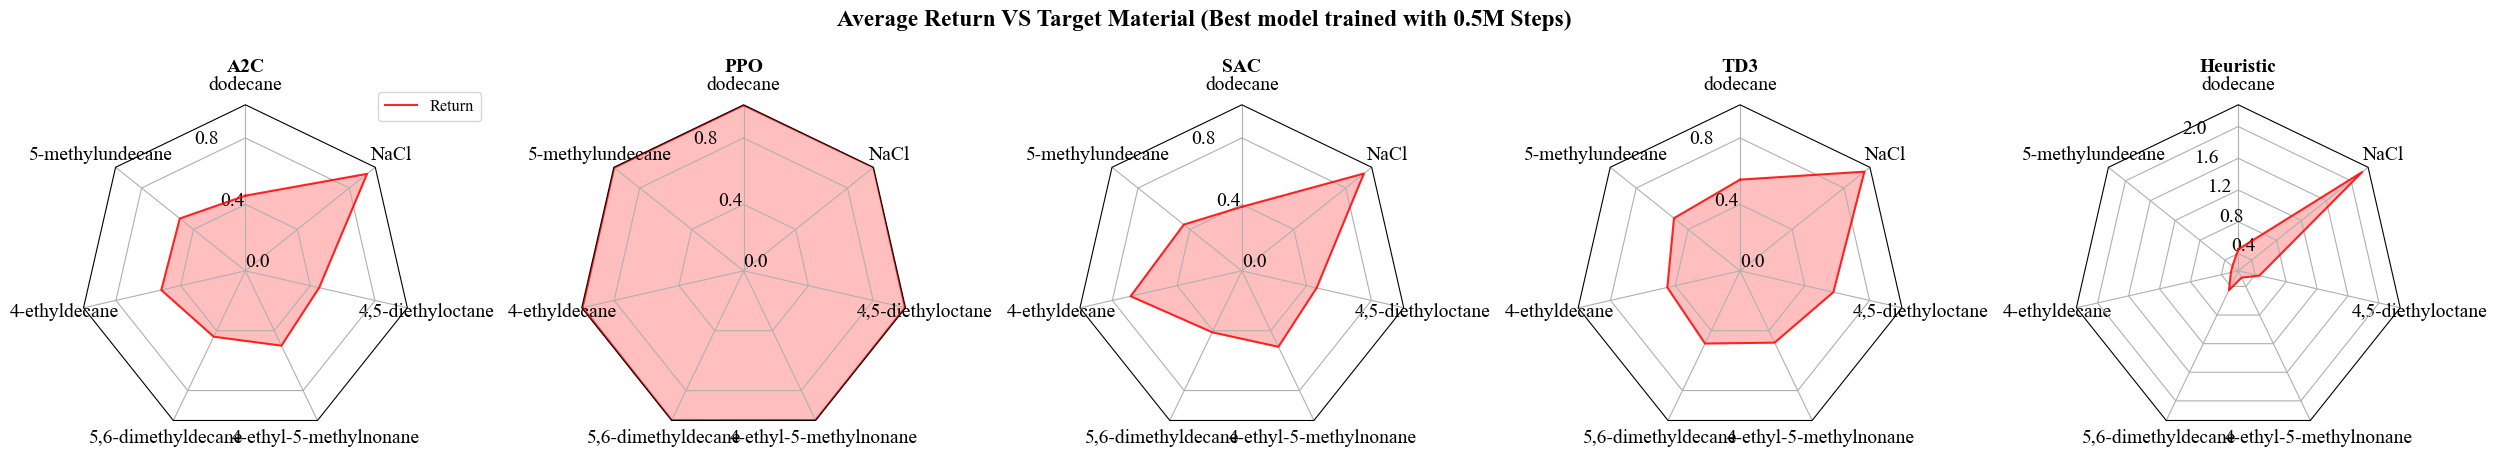

In [5]:
heuristic_rewards=get_conditional_rewards(gheuristic)[1]
radar_info={a:[get_conditional_rewards(folders[a])[1]/heuristic_rewards] for a in folders}

radar_info["Heuristic"] = [heuristic_rewards]

fig,axs = stat_show(radar_info,CWtargs,["Return"],figsize=(30,7))

#plt.savefig("Legacy\\Figures\\WurtzReact\\MeanGenWurtz.pdf",bbox_inches="tight")

#Add in a title
fig.text(0.5, 0.8, "Average Return VS Target Material (Best model trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

## Actions vs Timestep

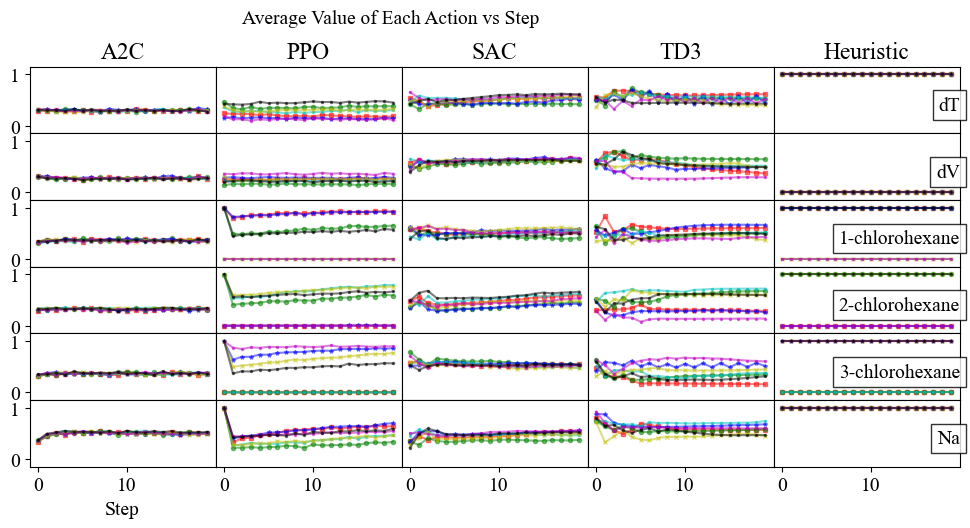

In [6]:
all_acts = []
for i in range(7):
    all_act = all_acts.append(([
    actions_by_time(target_subset(folders[name],len(CWtargs),i)) for name in folders]
    +[actions_by_time(target_subset(gheuristic,len(CWtargs),i))]))

colors = ["r","g","b","c","y","m","k"]
points = ['s-', 'o-', '*-', '.-','x-',".-",".-"]
labels = CWtargs

names=[name for name in folders]+["Heuristic"]

plotabt(all_acts,["dT","dV"]+CWchoices,colors,labels,points,names)



# Fict React

In [7]:
parent_dir = "MODELS\\FictReact-v2"
obj = lambda x: get_conditional_rewards(x,FRtargs)[1].mean()

folders = load_rollouts(parent_dir,obj=obj,last=False)
fheuristic = pd.read_pickle("MODELS\\FictReact-v2\\Heuristic\\rollout")

## Returns vs Training

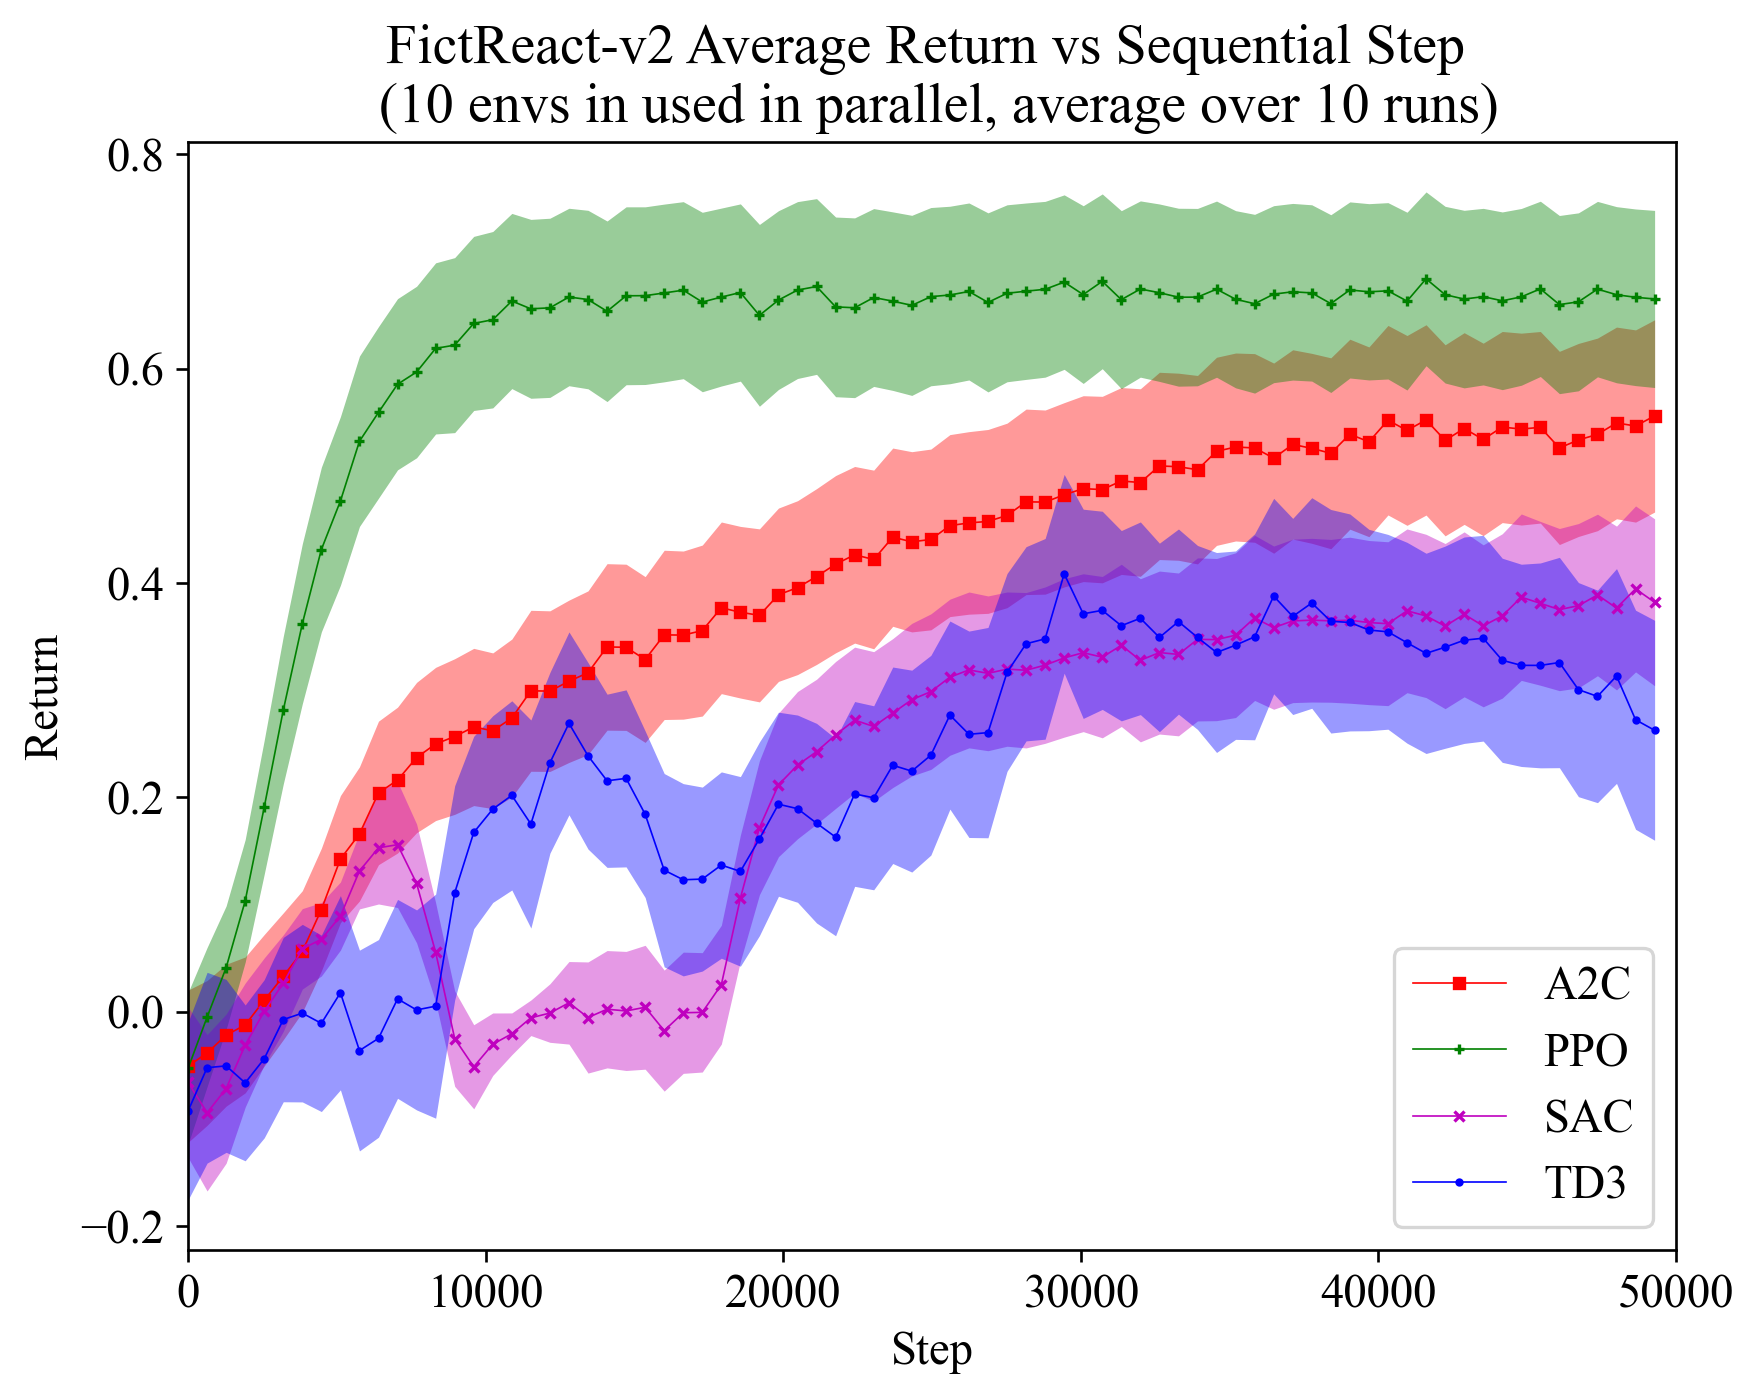

In [8]:
fig = plt.figure(1,figsize=(8,6), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=20,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=32)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv/5,mean+stdv/5,color=colors[i],alpha=0.4,lw=0)
    #plt.plot(np.arange(returns.shape[0])*20,returns,".",label=algo,alpha=0.3,mew=0,ms=8)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend()    
plt.savefig("Legacy/Figures/FictReact/FictReactRuns.pdf",bbox_inches='tight')
plt.title("FictReact-v2 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

## Returns vs Targets

Text(0.5, 0.8, 'Average Return VS Target Material (Best model trained with 0.5M Steps)')

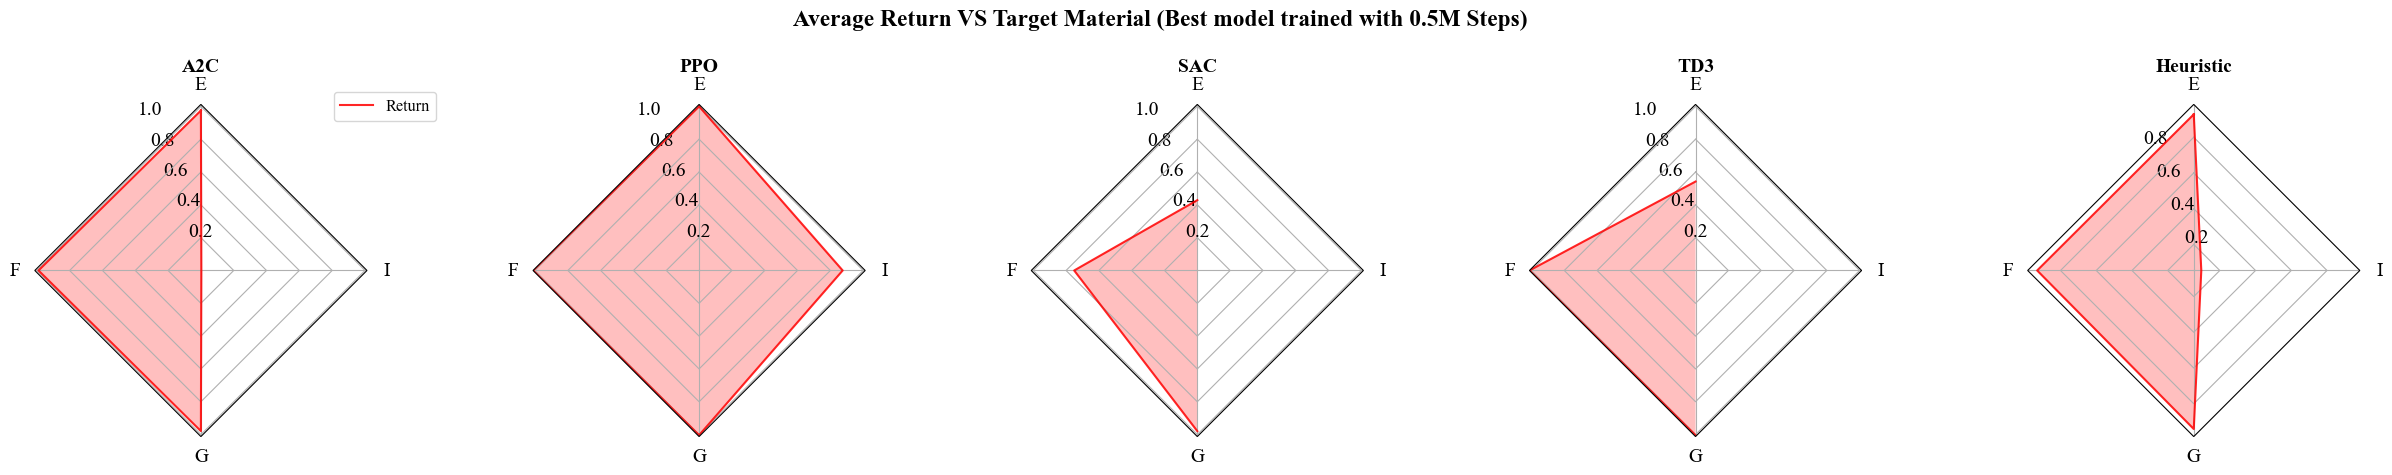

In [9]:
heuristic_rewards=get_conditional_rewards(fheuristic,FRtargs)[1]
radar_info={a:[get_conditional_rewards(folders[a],FRtargs)[1]/heuristic_rewards] for a in folders}

radar_info["Heuristic"] = [heuristic_rewards]

fig,axs = stat_show(radar_info,FRtargs,["Return"],figsize=(30,7),gridlines=[0.2,0.4,0.6,0.8,1.0])
#Add in a title

#plt.savefig("Legacy\\Figures\\FictReact\\MeanFict.pdf",bbox_inches="tight")

fig.text(0.5, 0.8, "Average Return VS Target Material (Best model trained with 0.5M Steps)",
             horizontalalignment='center', color='black', weight='bold',
             size='large')

## Actions Vs Timestep

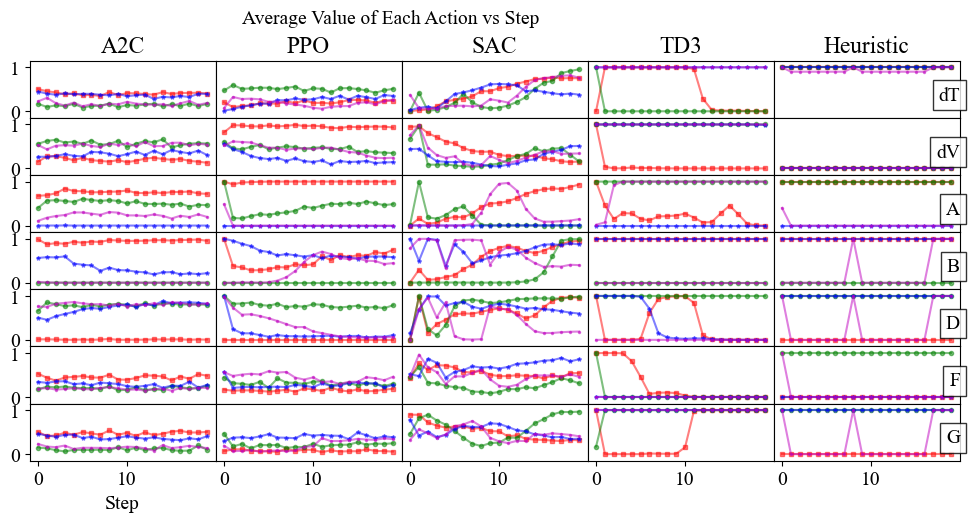

In [10]:
all_acts = []
for i in range(4):
    all_act = all_acts.append(([
    actions_by_time(target_subset(folders[name],len(FRtargs),i)) for name in folders]
    +[actions_by_time(target_subset(fheuristic,len(FRtargs),i))]))

colors = ["r","g","b","m"]
labels = ['E', 'F', 'G', 'I']
points = ['s-', 'o-', '*-', '.-']
names=[name for name in folders]+["Heuristic"]

plotabt(all_acts,["dT","dV"]+FRchoices,colors,labels,points,names)